In [1]:
import itertools

import sympy
import numpy
import matplotlib.pyplot as plt

from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json

In [2]:
c = lambda x: Concept(name=x)

templates = [
    ControlledConversion(controller=c('ATMa'), subject=c('TP53i'), outcome=c('TP53a')).with_mass_action_rate_law('kf_at_act_1'),
    ControlledConversion(controller=c('TP53a'), subject=c('PPM1Di'), outcome=c('PPM1Da')).with_mass_action_rate_law('kf_tp_act_1'),
    #ControlledConversion(controller=c('TP53a'), subject=c('MDM2i'), outcome=c('MDM2a')).with_mass_action_rate_law('kf_tm_act_1'),
    ControlledConversion(controller=c('ATMa'), subject=c('ATMi'), outcome=c('ATMa')).with_mass_action_rate_law('kf_aa_act_1'),
    ControlledConversion(controller=c('PPM1Da'), subject=c('TP53a'), outcome=c('TP53i')).with_mass_action_rate_law('kf_pt_act_1'),
    ControlledConversion(controller=c('PPM1Da'), subject=c('ATMa'), outcome=c('ATMi')).with_mass_action_rate_law('kf_pa_act_1'),
    #ControlledConversion(controller=c('MDM2a'), subject=c('TP53a'), outcome=c('TP53i')).with_mass_action_rate_law('kf_mt_act_1'),
    ControlledConversion(controller=c('HIPK2'), subject=c('PPM1Da'), outcome=c('PPM1Di')).with_mass_action_rate_law('kf_hp_act_1'),
    #ControlledConversion(controller=c('CDKN2A'), subject=c('MDM2a'), outcome=c('MDM2i')).with_mass_action_rate_law('kf_cm_act_1'),
]

In [3]:
templates = list(itertools.chain(*[conversion_to_deg_prod(t) for t in templates]))

In [4]:
parameters = {
    'kf_at_act_1': Parameter(name='kf_at_act_1', value=1e-07),
    'kf_tp_act_1': Parameter(name='kf_tp_act_1', value=1e-07),
    'kf_tm_act_1': Parameter(name='kf_tm_act_1', value=1e-07),
    'kf_aa_act_1': Parameter(name='kf_aa_act_1', value=5e-07),
    'kf_pt_act_1': Parameter(name='kf_pt_act_1', value=5e-07),
    'kf_pa_act_1': Parameter(name='kf_pa_act_1', value=1e-05),
    'kf_mt_act_1': Parameter(name='kf_mt_act_1', value=1e-07),
    'kf_hp_act_1': Parameter(name='kf_hp_act_1', value=1e-07),
    'kf_cm_act_1': Parameter(name='kf_cm_act_1', value=1e-07),
    'ATM_0': Parameter(name='ATM_0', value=10000.0),
    'TP53_0': Parameter(name='TP53_0', value=10000.0),
    'PPM1D_0': Parameter(name='PPM1D_0', value=10000.0),
    'MDM2_0': Parameter(name='MDM2_0', value=10000.0),
    'HIPK2_0': Parameter(name='HIPK2_0', value=10000.0),
    'CDKN2A_0': Parameter(name='CDKN2A_0', value=10000.0),
    'ATMa_0': Parameter(name='ATMa_0', value=1.0)
}

In [5]:
initials = {
    'ATMi_0': Initial(concept=Concept(name='ATMi'), expression=sympy.Symbol('ATM_0')),
    'TP53i_0': Initial(concept=Concept(name='TP53i'), expression=sympy.Symbol('TP53_0')),
    'PPM1Di_0': Initial(concept=Concept(name='PPM1Di'), expression=sympy.Symbol('PPM1D_0')),
    'MDM2i_0': Initial(concept=Concept(name='MDM2i'), expression=sympy.Symbol('MDM2_0')),
    'HIPK2_0': Initial(concept=Concept(name='HIPK2'), expression=sympy.Symbol('HIPK2_0')),
    'CDKN2A_0': Initial(concept=Concept(name='CDKN2A'), expression=sympy.Symbol('CDKN2A_0')),
    'ATMa_0': Initial(concept=Concept(name='ATMa'), expression=sympy.Symbol('ATMa_0')),
    'TP53a_0': Initial(concept=Concept(name='TP53a'), expression=0),
    'PPM1Da_0': Initial(concept=Concept(name='PPM1Da'), expression=0),
    'MDM2a_0': Initial(concept=Concept(name='MDM2a'), expression=0),
}

In [6]:
tm = TemplateModel(templates=templates,
                   parameters=parameters,
                   initials=initials)

In [7]:
om = OdeModel(Model(tm), initialized=True)
om.kinetics

Matrix([
[-p[0, 0]*y[0, 0]*y[1, 0] + p[3, 0]*y[2, 0]*y[4, 0]],
[ p[2, 0]*y[1, 0]*y[5, 0] - p[4, 0]*y[1, 0]*y[4, 0]],
[ p[0, 0]*y[0, 0]*y[1, 0] - p[3, 0]*y[2, 0]*y[4, 0]],
[-p[1, 0]*y[2, 0]*y[3, 0] + p[5, 0]*y[4, 0]*y[6, 0]],
[ p[1, 0]*y[2, 0]*y[3, 0] - p[5, 0]*y[4, 0]*y[6, 0]],
[-p[2, 0]*y[1, 0]*y[5, 0] + p[4, 0]*y[1, 0]*y[4, 0]],
[                                                 0]])

In [8]:
ts = numpy.linspace(0, 1e5, 1000)
res = simulate_ode_model(om, times=ts)

Text(0, 0.5, '# Molecules')

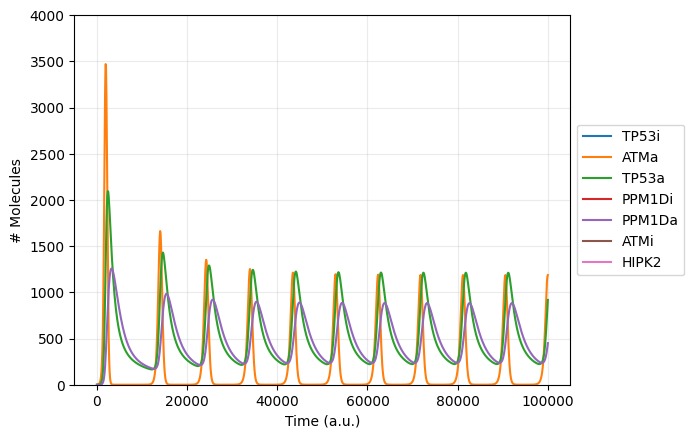

In [9]:
plt.plot(ts, res, label=om.vmap.keys())
plt.grid(alpha=0.25)
plt.ylim([0,4000])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (a.u.)')
plt.ylabel('# Molecules')

In [10]:
frameworks = {'regnet': template_model_to_regnet_json, 'petrinet': template_model_to_petrinet_json}

for fkey, fun in frameworks.items():
    with open(f'atm_{fkey}.json', 'w') as fh:
        json.dump(fun(tm), fh, indent=1)